In [1]:
import pandas as pd
import numpy as np

In [45]:
transactions = pd.read_csv('./Data/InitTraining.csv')

In [46]:
transactions.head()

,Date,Category,Sub-category,Amount,Account,Balance
0,2023-01-01,Food & Drinks,Drinks,-200.00,Credit,-200
1,2023-01-01,Food & Drinks,Take-out,-40.45,Credit,-240.45
2,2023-01-02,Housing,Rent,-650.00,Cash Hub,"2,850.00"
3,2023-01-02,Food & Drinks,Coffee,-5.74,Cash Hub,"2,844.26"
4,2023-01-02,Utilities,Phone,-58.04,Cash Hub,"2,786.22"


In [47]:
transactions.replace({'Category' : {'Personal' : 'Personal Care'}}, inplace = True)
transactions.replace(',', '',regex=True, inplace=True)
transactions = transactions.astype({'Amount': float, 'Balance': float})
basic_transactions = transactions.drop(columns=['Balance', 'Account'])
transactions['Date'] = pd.to_datetime(transactions['Date'])
basic_transactions['Date'] = pd.to_datetime(basic_transactions['Date'])
transactions.set_index('Date', inplace=True)
basic_transactions.set_index('Date', inplace=True)

In [53]:
food = transactions[transactions['Category'] == 'Food & Drinks']
housing = transactions[transactions['Category'] == 'Housing']
utilities = transactions[transactions['Category'] == 'Utilities']
personal = transactions[transactions['Category'] == 'Personal Care']
entertainment = transactions[transactions['Category'] == 'Entertainment']
income = transactions[transactions['Category'] == 'Income']
transportation = transactions[transactions['Category'] == 'Transportation']
debt = transactions[transactions['Category'] == 'Debt']
lifestyle = transactions[transactions['Category'] == 'Lifestyle']
bank = transactions[transactions['Category'] == 'Bank']
investment = transactions[transactions['Category'] == 'Investment']
savings = transactions[transactions['Category'] == 'Savings']

In [54]:
basic_food = basic_transactions[basic_transactions['Category'] == 'Food & Drinks']
basic_housing = basic_transactions[basic_transactions['Category'] == 'Housing']
basic_utilities = basic_transactions[basic_transactions['Category'] == 'Utilities']
basic_personal = basic_transactions[basic_transactions['Category'] == 'Personal Care']
basic_entertainment = basic_transactions[basic_transactions['Category'] == 'Entertainment']
basic_income = basic_transactions[basic_transactions['Category'] == 'Income']
basic_transportation = basic_transactions[basic_transactions['Category'] == 'Transportation']
basic_debt = basic_transactions[basic_transactions['Category'] == 'Debt']
basic_lifestyle = basic_transactions[basic_transactions['Category'] == 'Lifestyle']
basic_bank = basic_transactions[basic_transactions['Category'] == 'Bank']
basic_investment = basic_transactions[basic_transactions['Category'] == 'Investment']
basic_savings = basic_transactions[basic_transactions['Category'] == 'Savings']

In [55]:
income.head()

,Category,Sub-category,Amount,Account,Balance
Date,,,,,
2023-01-06,Income,Salary,509.08,Cash Hub,3265.30
2023-01-20,Income,Salary,708.96,Cash Hub,3888.06
2023-02-03,Income,Salary,640.82,Cash Hub,3253.87
2023-02-17,Income,Salary,334.84,Cash Hub,3534.59
2023-03-03,Income,Salary,340.94,Cash Hub,2596.42


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

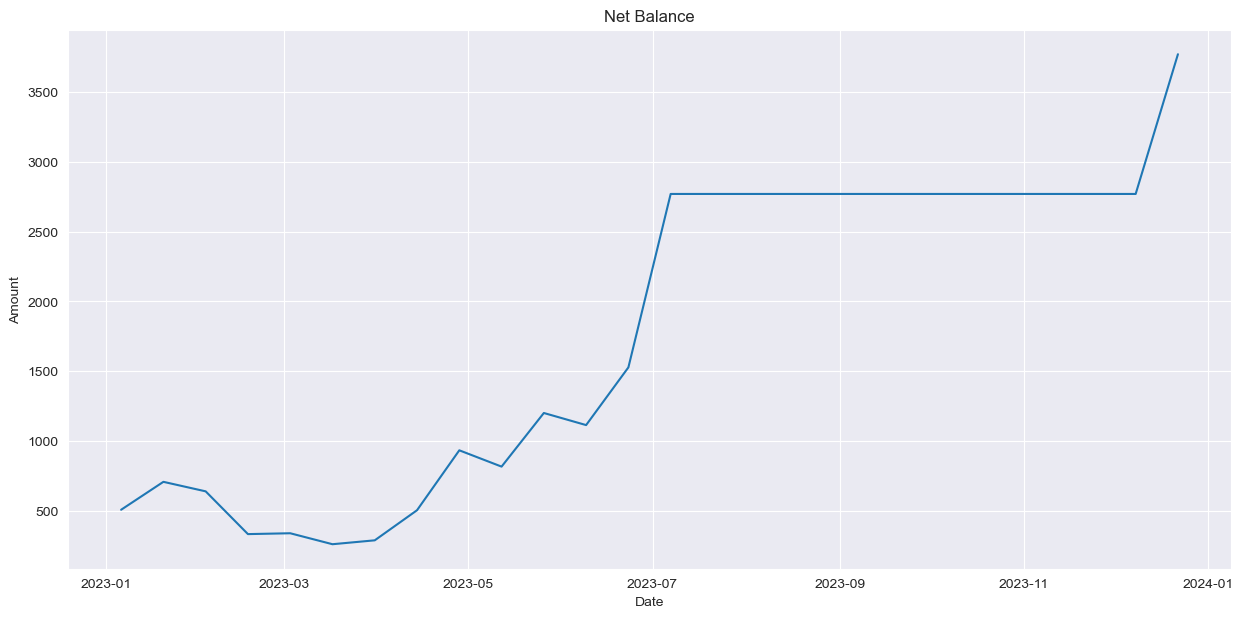

In [59]:
plt.figure(figsize=(15,7))
plt.title("Net Balance")
plt.xlabel('Date')
plt.ylabel('Amount')
plt.plot(basic_income['Amount'])
plt.show()

In [63]:
income_copy = income.copy()

In [85]:
income_copy['rolling_avg'] = income['Amount'].rolling(window=12).mean()

In [86]:
income_copy['rolling_std'] = income['Amount'].rolling(window=12).std()

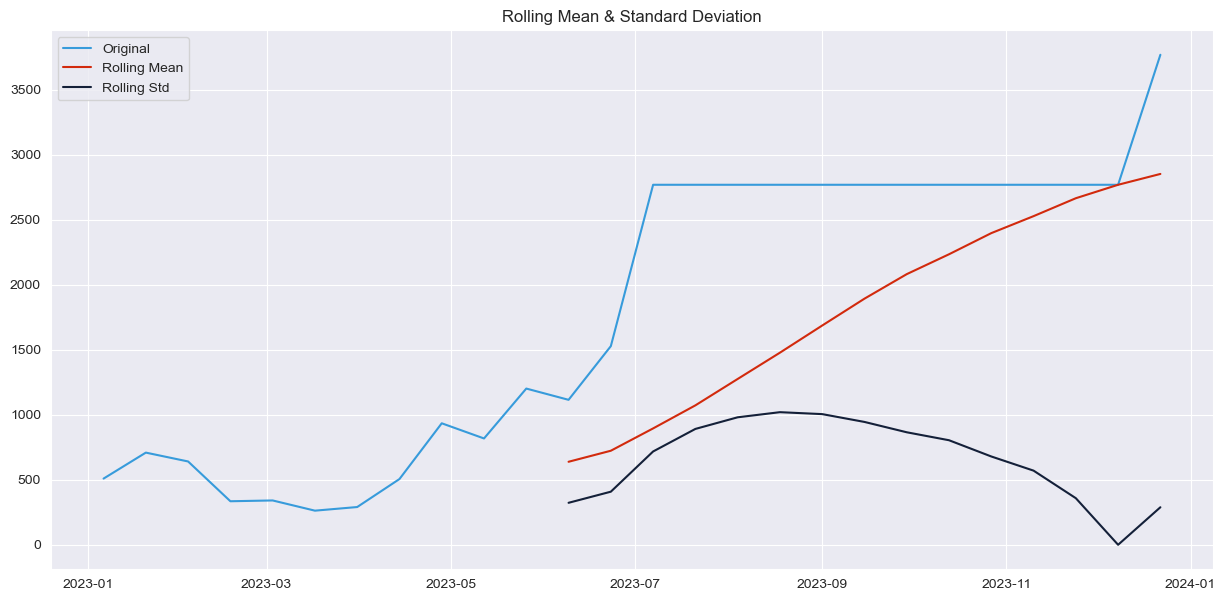

In [87]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(income_copy["Amount"], color='#379BDB', label='Original')
plt.plot(income_copy["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(income_copy["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [88]:
from statsmodels.tsa.stattools import adfuller

In [89]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(income_copy['Amount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.099246
p-value                         0.949514
#Lags Used                      0.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [90]:
import pmdarima as pm

In [92]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(income_copy['Amount'],
                            start_p=1,
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

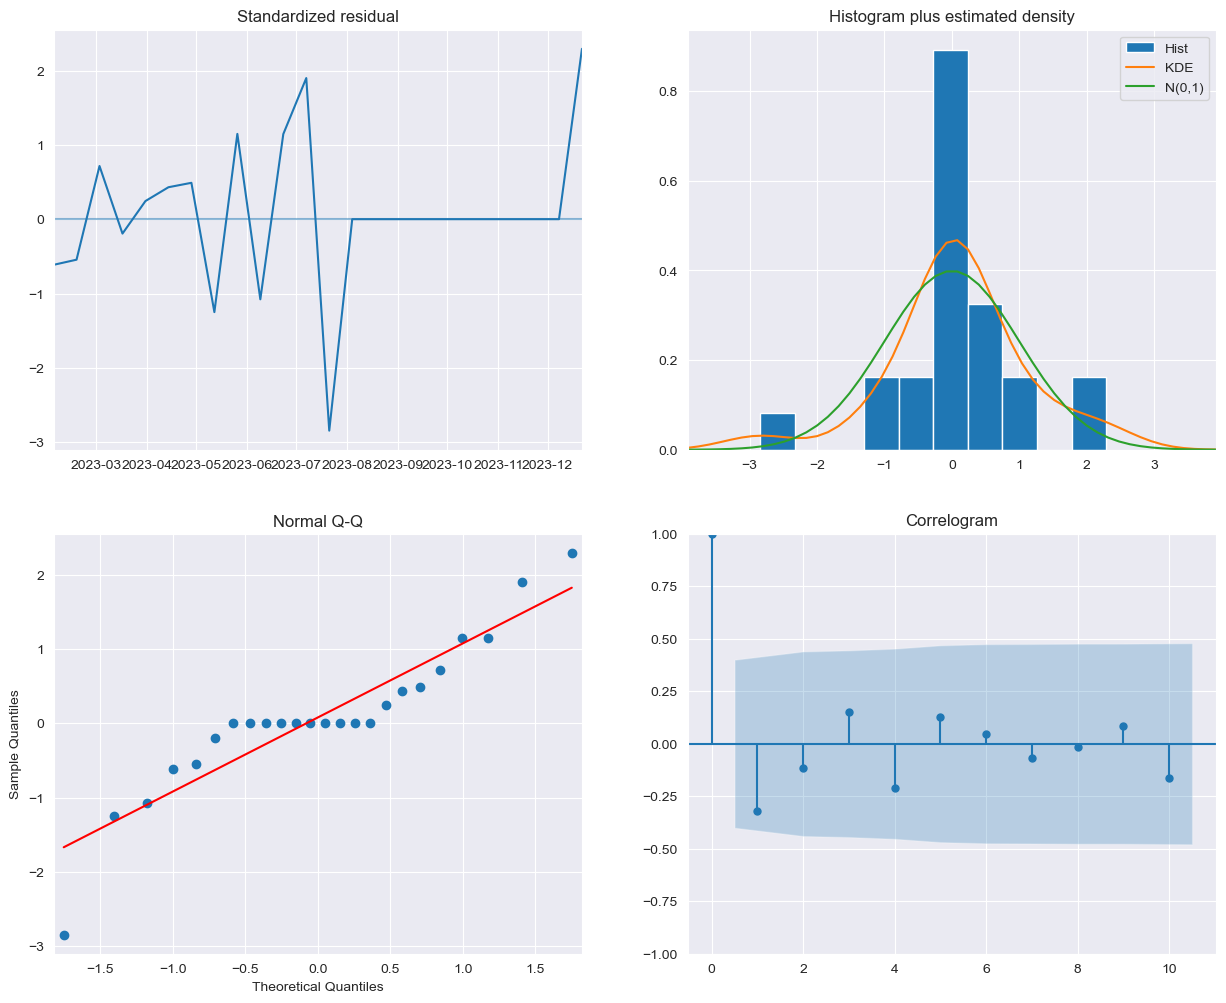

In [93]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

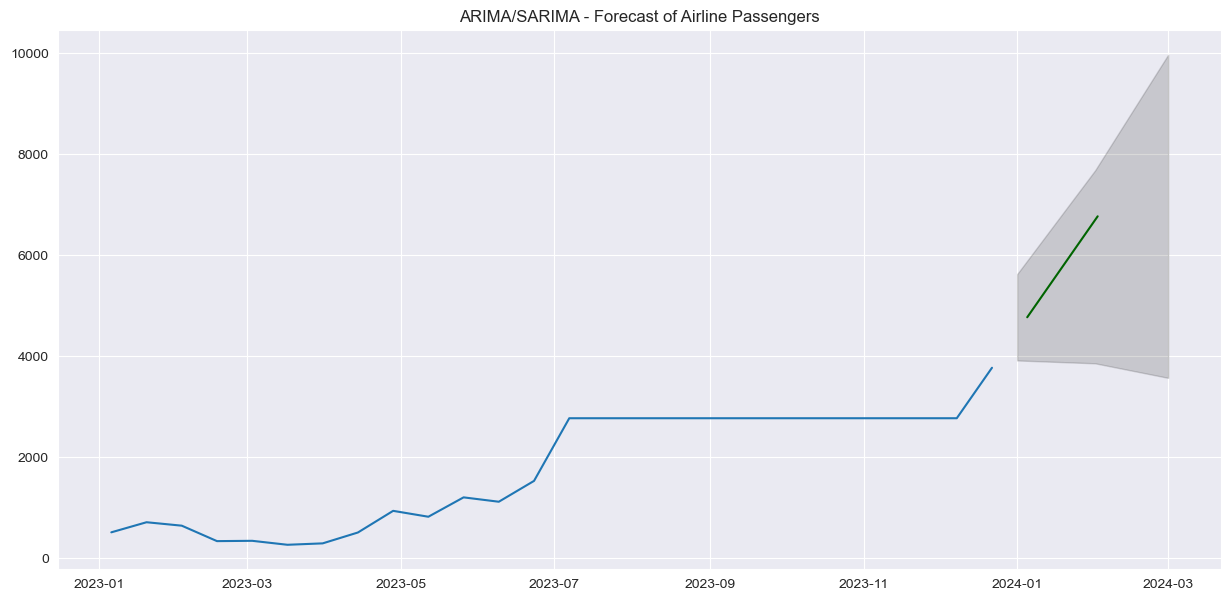

In [112]:
def forecast(ARIMA_model, periods=3):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(income_copy.index[-1] + pd.DateOffset(days=0), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(income_copy["Amount"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [114]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(income_copy["Amount"], start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3,
                             m=12, #12 is the frequncy of the cycle
                             start_P=0,
                             seasonal=True, #set to seasonal
                             d=None,
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

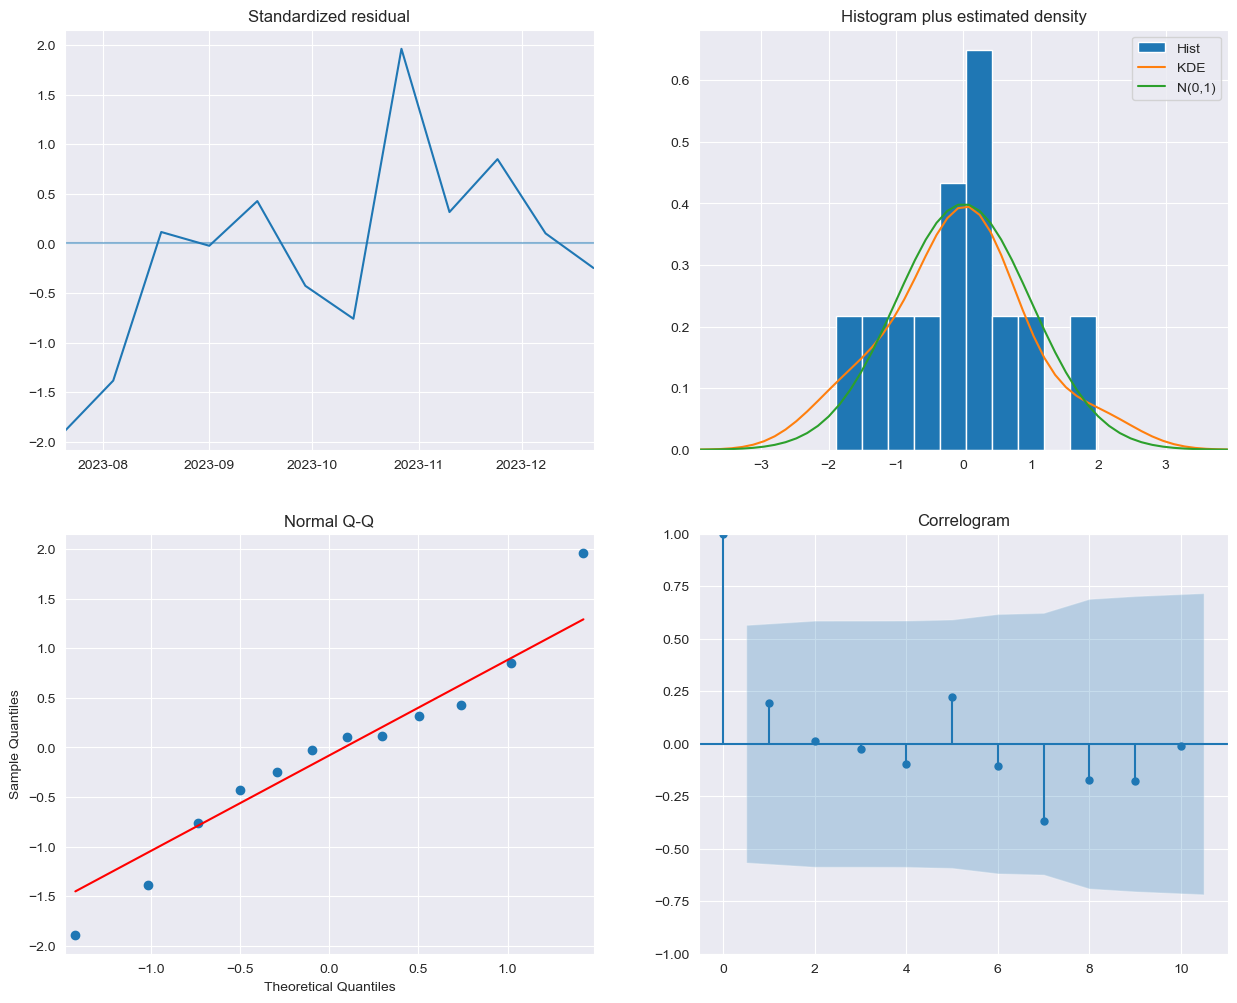

In [115]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

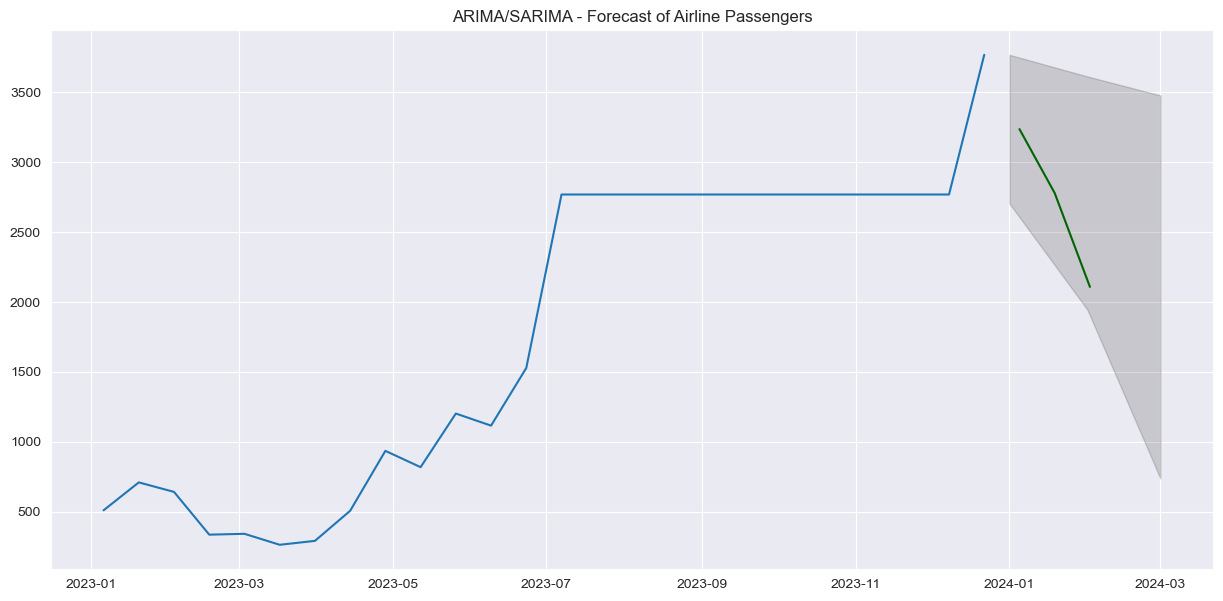

In [116]:
forecast(SARIMA_model)

In [117]:
transactions['Category'].unique()

array(['Food & Drinks', 'Housing', 'Utilities', 'Personal Care',
       'Entertainment', 'Income', 'Transportation', 'Debt', 'Lifestyle',
       'Bank', 'Investment', 'Savings'], dtype=object)

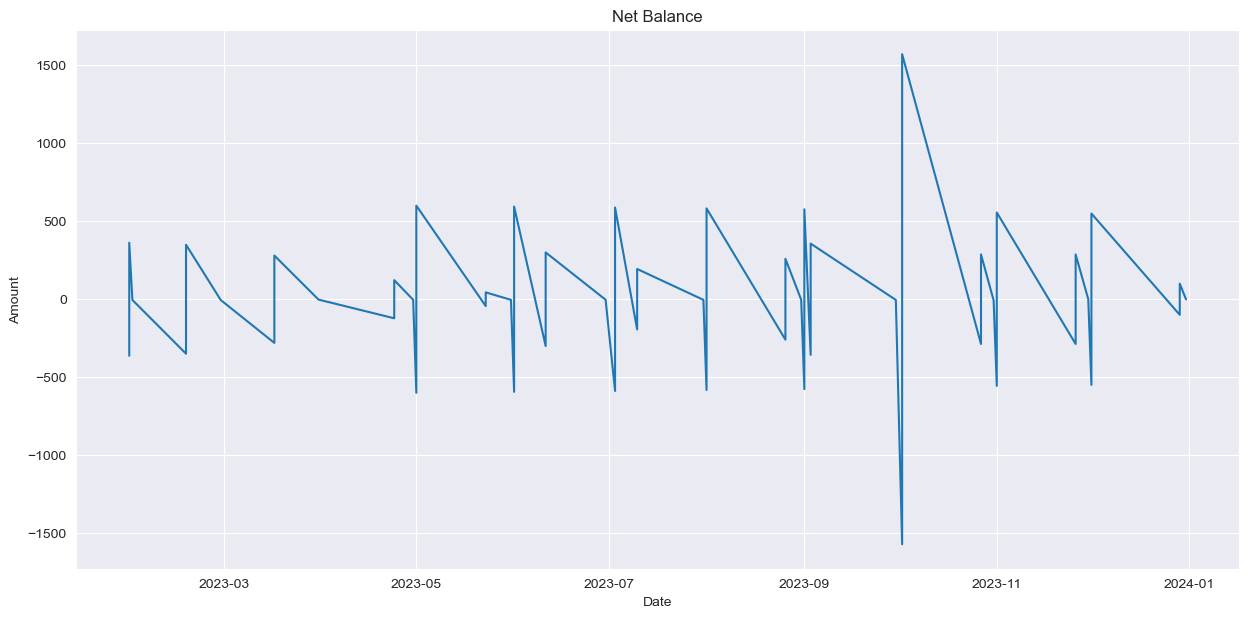

In [122]:
plt.figure(figsize=(15,7))
plt.title("Net Balance")
plt.xlabel('Date')
plt.ylabel('Amount')
plt.plot(basic_debt['Amount'])
plt.show()

In [123]:
debt_copy = basic_debt.copy()

In [124]:
debt_copy['rolling_avg'] = debt['Amount'].rolling(window=12).mean()
debt_copy['rolling_std'] = debt['Amount'].rolling(window=12).std()

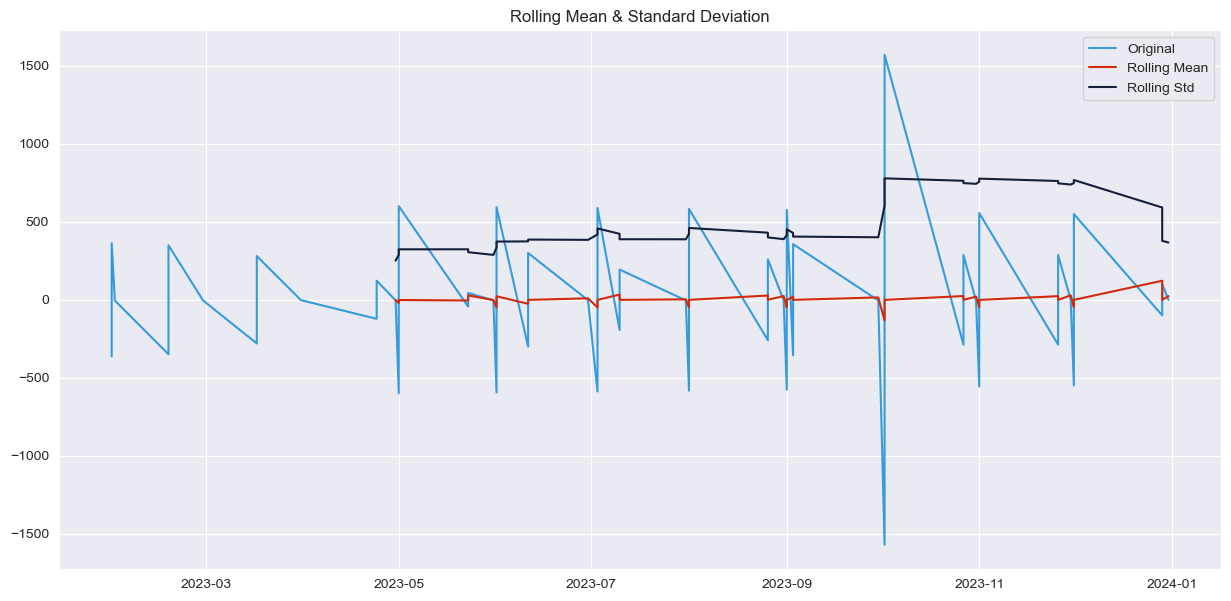

In [125]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(debt_copy["Amount"], color='#379BDB', label='Original')
plt.plot(debt_copy["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(debt_copy["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [126]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(debt_copy['Amount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.078044e+01
p-value                        2.262391e-19
#Lags Used                     3.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


In [127]:
#Standard ARIMA Model
debt_model = pm.auto_arima(debt_copy['Amount'],
                            start_p=1,
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

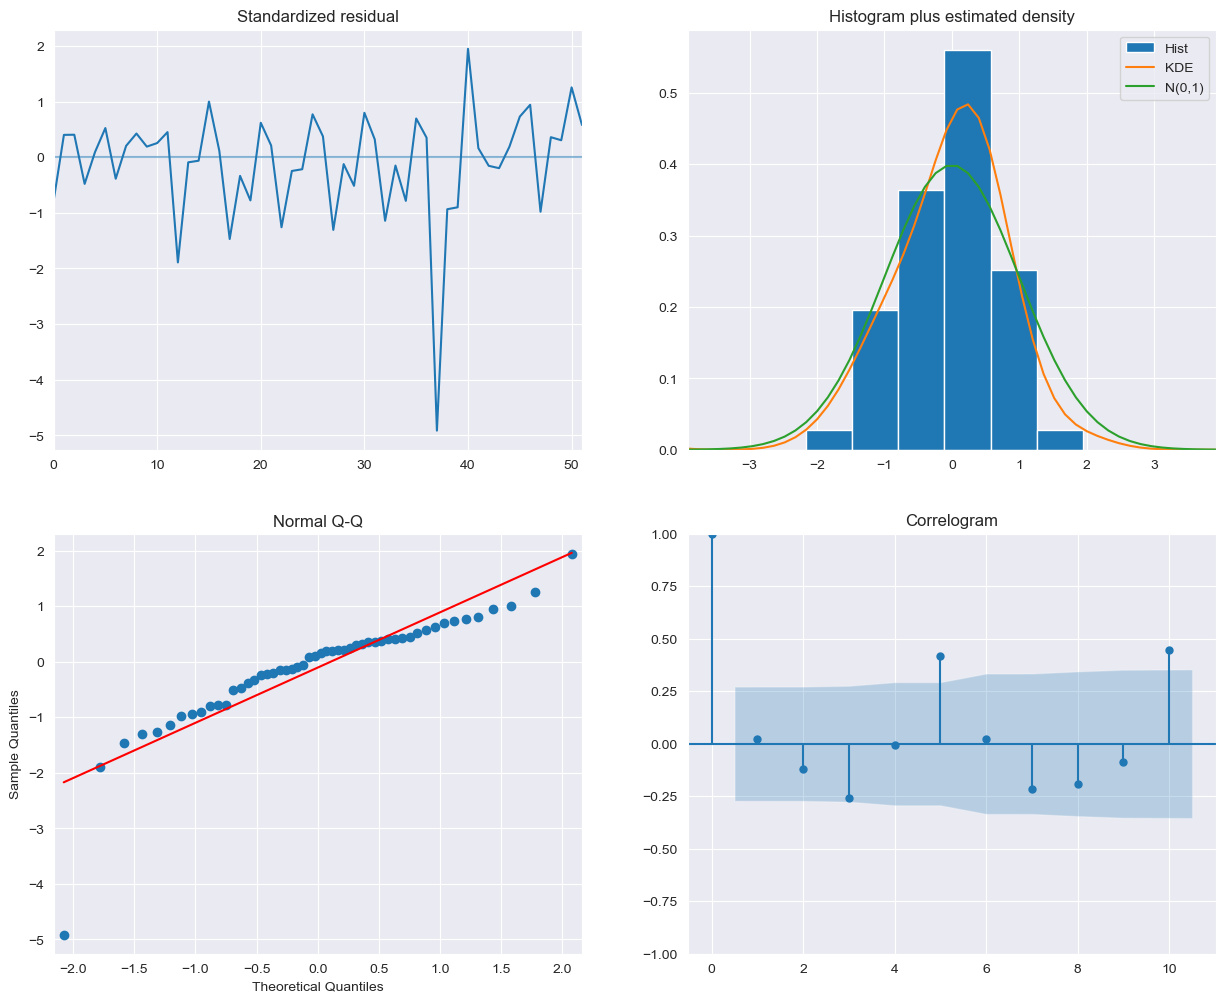

In [128]:
debt_model.plot_diagnostics(figsize=(15,12))
plt.show()

C:\Users\peter\miniconda3\envs\Ledgr\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peter\miniconda3\envs\Ledgr\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


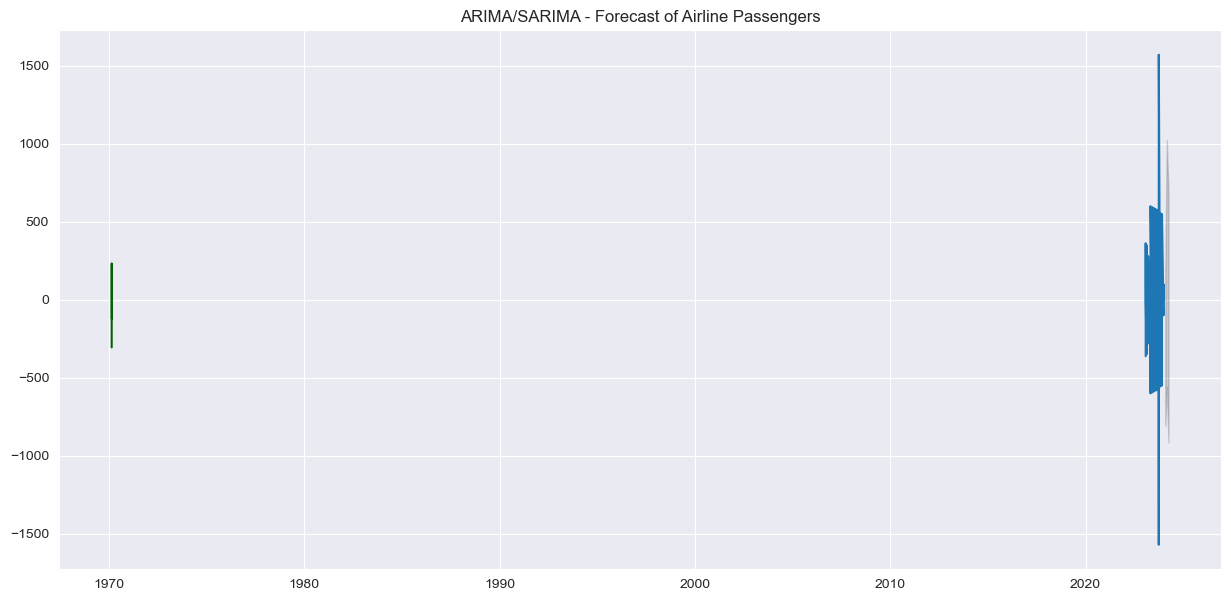

In [134]:
def debt_forecast(debt_model, periods=3):
    # Forecast
    n_periods = periods
    fitted, confint = debt_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(debt_copy.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(debt_copy["Amount"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

debt_forecast(debt_model)